DL_Homework 3 <br/>
Motahare Hazrati<br/>
400206613


part 1

In [50]:
from torchvision.models import resnet50, ResNet50_Weights
import tensorflow as tf
from torchvision.io import read_image
import tensorflow.keras as K
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval()


preprocess = weights.transforms()

input_t=K.Input(shape=(32,32,3))
res_model = K.applications.ResNet50(include_top=False, weights="imagenet",
                                    input_tensor=input_t)
for layer in res_model.layers[:175]:
    layer.trainable = False
model=K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(10,activation='softmax'))

import tensorflow.keras as K
def preprocess_data (X,Y):
  X_P=K.applications.resnet50.preprocess_input(X)
  Y_P=K.utils.to_categorical(Y,10)
  return X_P, Y_P

(x_train, y_train),(x_test,y_test)=K.datasets.cifar10.load_data()
print(x_train.shape,y_train.shape)
x_train, y_train = preprocess_data(x_train,y_train)
x_test, y_test = preprocess_data(x_test,y_test)
print(x_train.shape,y_train.shape)

(50000, 32, 32, 3) (50000, 1)
(50000, 32, 32, 3) (50000, 10)


In [51]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train,batch_size=32, epochs=10, verbose=1,validation_data=(x_test,y_test))

model.save("RN50.h5")


Epoch 1/10
1563/1563 [==============================] - 29s 17ms/step - loss: 1.5689 - accuracy: 0.5763 - val_loss: 1.4056 - val_accuracy: 0.6096
Epoch 2/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.2265 - accuracy: 0.6419 - val_loss: 1.3420 - val_accuracy: 0.6250
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1715 - accuracy: 0.6608 - val_loss: 1.5240 - val_accuracy: 0.6050
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1430 - accuracy: 0.6669 - val_loss: 1.4986 - val_accuracy: 0.6163
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1366 - accuracy: 0.6708 - val_loss: 1.4540 - val_accuracy: 0.6252
Epoch 6/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1213 - accuracy: 0.6761 - val_loss: 1.5118 - val_accuracy: 0.6229
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.1171 - accuracy: 0.6788 - val_loss: 1.5785 -

In [52]:
import keras
from matplotlib import pyplot as plt

def plot_history(history):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

def plott2(history,data,data2):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel(data, fontsize=16)
    plt.plot(history.history[data], label='Training Loss')
    plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.ylabel(data2, fontsize=16)
    plt.plot(history.history[data2], label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.show()

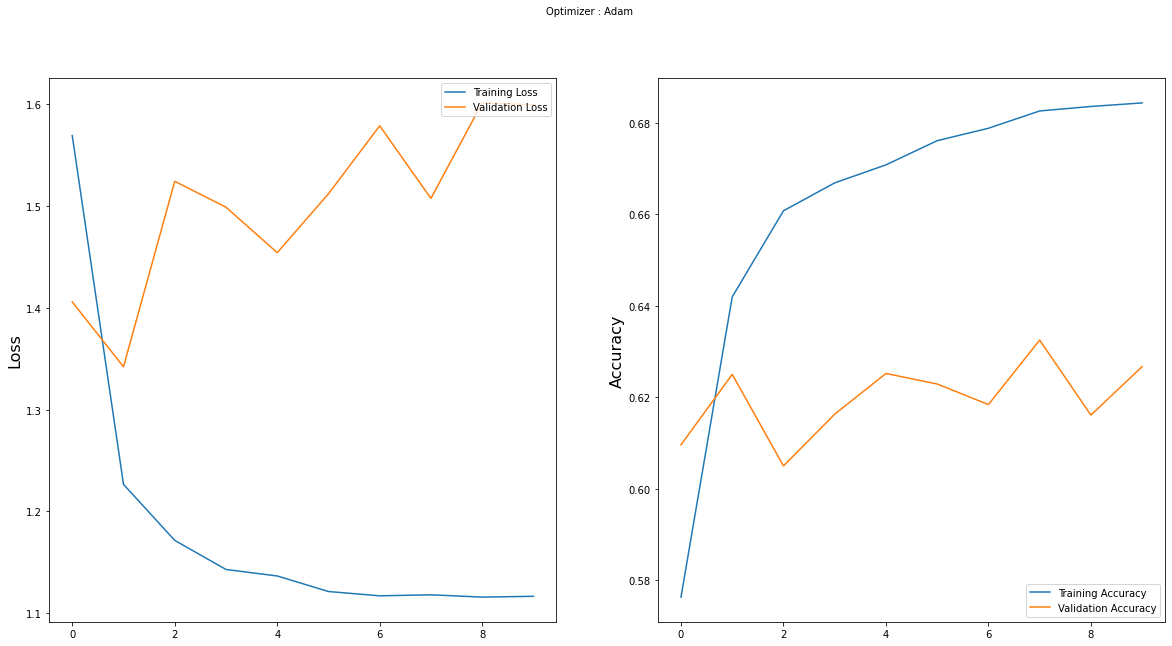

In [53]:
plot_history(history)

part 2

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):

        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)

            student_loss = self.student_loss_fn(y, student_predictions)

            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
   
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [55]:
 pip install git+https://github.com/qubvel/classification_models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-vakxylua
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-vakxylua
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [56]:

from tensorflow import keras
teacher = keras.models.load_model('RN50.h5')

import numpy as np
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import decode_predictions
from classification_models.keras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')
student = ResNet18((32, 32, 3), classes=10)

student_scratch = keras.models.clone_model(student)

In [57]:
import numpy as np

y_train=np.where(y_train==1)[1]
y_test=np.where(y_test==1)[1]

In [58]:

distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.15,
    temperature=8,
)

history_dist=distiller.fit(x_train, y_train, epochs=3)

distiller.evaluate(x_test, y_test)

Epoch 1/3


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 54s 32ms/step - sparse_categorical_accuracy: 0.4945 - student_loss: 1.4097 - distillation_loss: 0.0249
Epoch 2/3
1563/1563 [==============================] - 46s 29ms/step - sparse_categorical_accuracy: 0.6498 - student_loss: 1.0059 - distillation_loss: 0.0203
Epoch 3/3
313/313 [==============================] - 2s 7ms/step - sparse_categorical_accuracy: 0.7002 - student_loss: 0.8561


[0.7002000212669373, 0.7913462519645691]

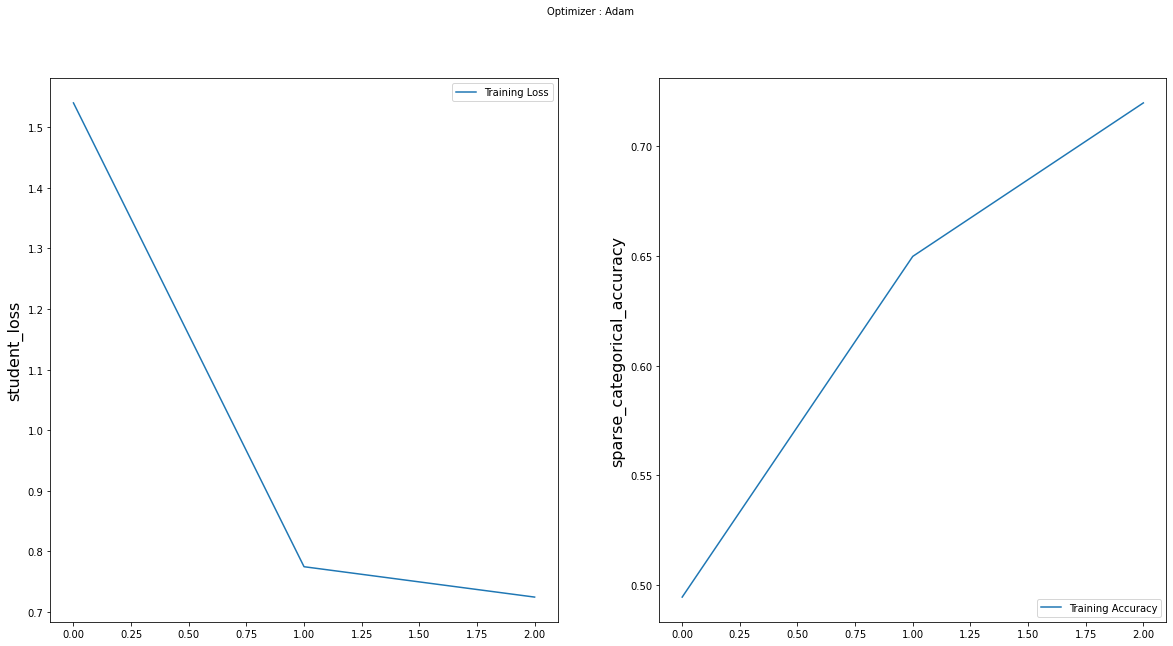

In [59]:
plott2(history_dist,'student_loss','sparse_categorical_accuracy')

In [60]:
distiller.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - sparse_categorical_accuracy: 0.7002 - student_loss: 0.8561


[0.7002000212669373, 0.7913462519645691]

In [61]:

student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


history_student=student_scratch.fit(x_train, y_train, epochs=3)
student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1563/1563 [==============================] - 33s 20ms/step - loss: 1.4158 - sparse_categorical_accuracy: 0.4932
Epoch 2/3
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0193 - sparse_categorical_accuracy: 0.6435
Epoch 3/3
313/313 [==============================] - 2s 7ms/step - loss: 0.8585 - sparse_categorical_accuracy: 0.7086


[0.8584771752357483, 0.7085999846458435]

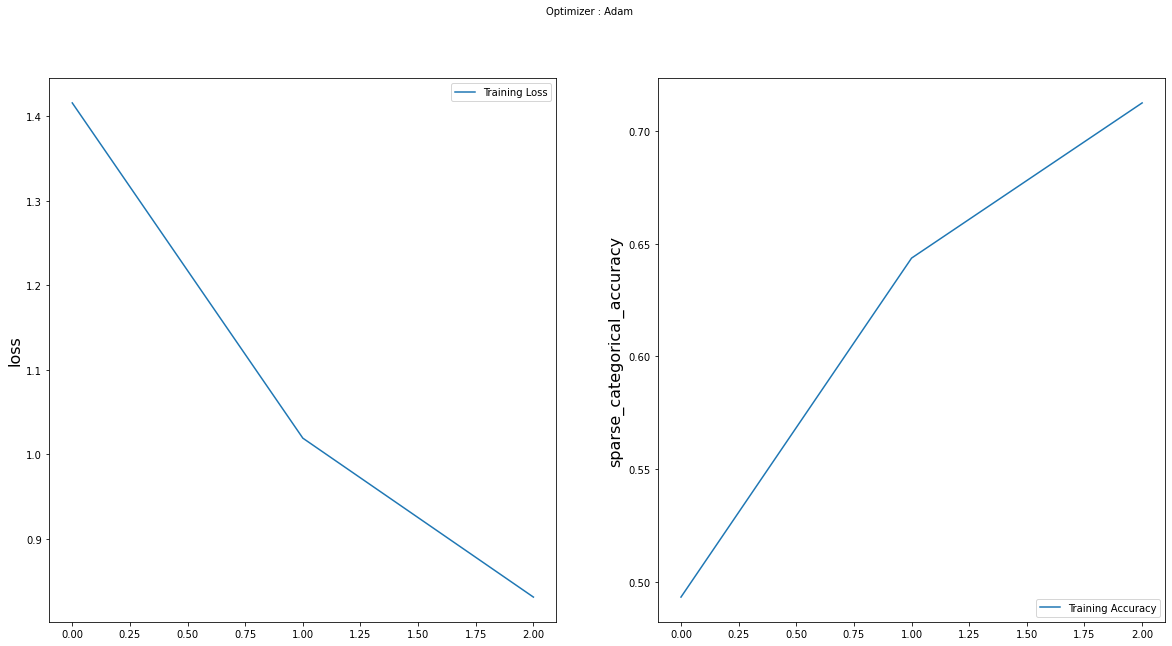

In [62]:
plott2(history_student,'loss','sparse_categorical_accuracy')

part 3

we need more epoches but the accuracy for part 3 is better. loss decends in part 3 more than previous part. but in student-teacher method, model trained faster with acceptable accuracy and loss.



In [63]:
from classification_models.keras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')


res_model = ResNet18((32, 32, 3), classes=10)
model=K.models.Sequential()
model.add(res_model)

(x_train, y_train),(x_test,y_test)=K.datasets.cifar10.load_data()
print(x_train.shape,y_train.shape)
x_train, y_train = preprocess_data(x_train,y_train)
x_test, y_test = preprocess_data(x_test,y_test)
print(x_train.shape,y_train.shape)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
historyResnet18=model.fit(x_train,y_train,batch_size=32, epochs=10, verbose=1,
                  validation_data=(x_test,y_test))
model.summary()

(50000, 32, 32, 3) (50000, 1)
(50000, 32, 32, 3) (50000, 10)
Epoch 1/10
1563/1563 [==============================] - 34s 21ms/step - loss: 1.4137 - accuracy: 0.4972 - val_loss: 1.1566 - val_accuracy: 0.5988
Epoch 2/10
1563/1563 [==============================] - 32s 21ms/step - loss: 1.0094 - accuracy: 0.6483 - val_loss: 0.9661 - val_accuracy: 0.6601
Epoch 3/10
1563/1563 [==============================] - 32s 21ms/step - loss: 0.8192 - accuracy: 0.7163 - val_loss: 0.8273 - val_accuracy: 0.7129
Epoch 4/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.6767 - accuracy: 0.7669 - val_loss: 0.7711 - val_accuracy: 0.7337
Epoch 5/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.5757 - accuracy: 0.8013 - val_loss: 0.7246 - val_accuracy: 0.7565
Epoch 6/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.4769 - accuracy: 0.8377 - val_loss: 0.7363 - val_accuracy: 0.7578
Epoch 7/10
1563/1563 [==============================] - 31s 20m

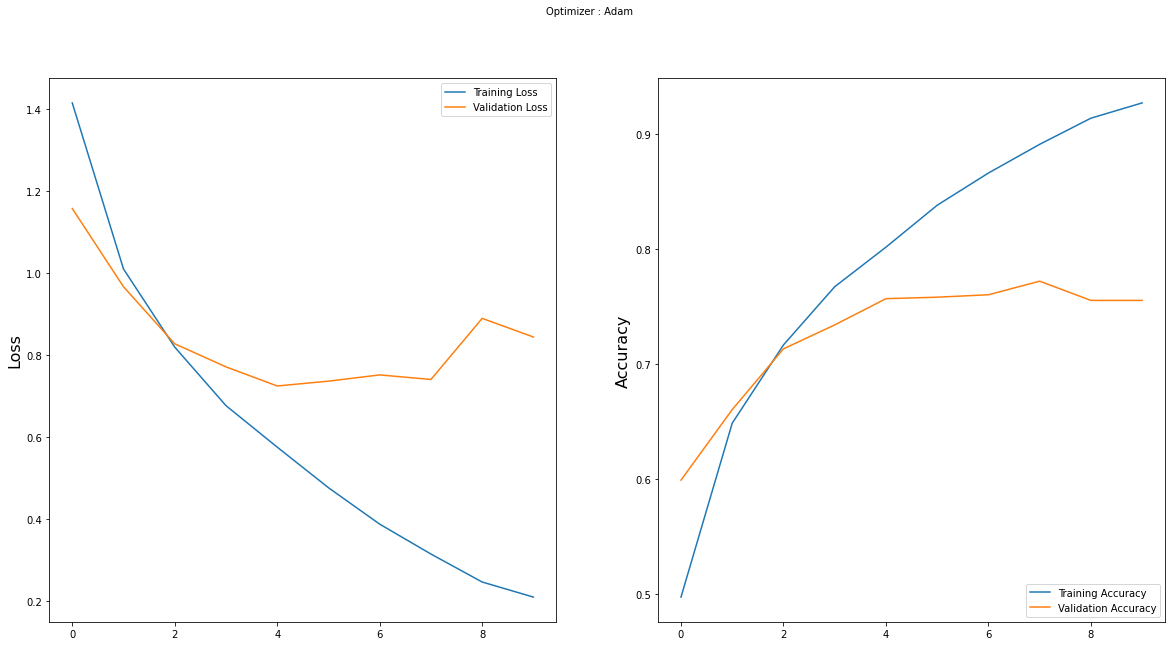

In [64]:
plot_history(historyResnet18)

part 4

Fine Tune Part

In [65]:
from torchvision.models import resnet50, ResNet50_Weights
import tensorflow as tf
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval()
preprocess = weights.transforms()
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [66]:
import tensorflow.keras as K
def preprocess_data (X,Y):
  X_P=K.applications.resnet50.preprocess_input(X)
  Y_P=K.utils.to_categorical(Y,10)
  return X_P, Y_P

input_t=K.Input(shape=(32,32,3))
res_model = K.applications.ResNet50(include_top=False, weights="imagenet",
                                    input_tensor=input_t)
model=K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(10,activation='softmax'))

(x_train, y_train),(x_test,y_test)=K.datasets.cifar10.load_data()
print(x_train.shape,y_train.shape)
x_train, y_train = preprocess_data(x_train,y_train)
x_test, y_test = preprocess_data(x_test,y_test)
print(x_train.shape,y_train.shape)




(50000, 32, 32, 3) (50000, 1)
(50000, 32, 32, 3) (50000, 10)


In [67]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy'])
historyfine=model.fit(x_train,y_train,batch_size=32, epochs=10, verbose=1,
                  validation_data=(x_test,y_test))
model.summary()

Epoch 1/10
1563/1563 [==============================] - 67s 40ms/step - loss: 1.7539 - accuracy: 0.4635 - val_loss: 2.4703 - val_accuracy: 0.3547
Epoch 2/10
1563/1563 [==============================] - 60s 38ms/step - loss: 1.5864 - accuracy: 0.4979 - val_loss: 1.8210 - val_accuracy: 0.4519
Epoch 3/10
1563/1563 [==============================] - 60s 38ms/step - loss: 1.4271 - accuracy: 0.5443 - val_loss: 2.7676 - val_accuracy: 0.3722
Epoch 4/10
1563/1563 [==============================] - 60s 38ms/step - loss: 1.4650 - accuracy: 0.5299 - val_loss: 1.9354 - val_accuracy: 0.4466
Epoch 5/10
1563/1563 [==============================] - 60s 38ms/step - loss: 1.4682 - accuracy: 0.5428 - val_loss: 2.0019 - val_accuracy: 0.4452
Epoch 6/10
1563/1563 [==============================] - 61s 39ms/step - loss: 1.3498 - accuracy: 0.5738 - val_loss: 1.4781 - val_accuracy: 0.5331
Epoch 7/10
1563/1563 [==============================] - 60s 38ms/step - loss: 1.1980 - accuracy: 0.6154 - val_loss: 1.9698 -

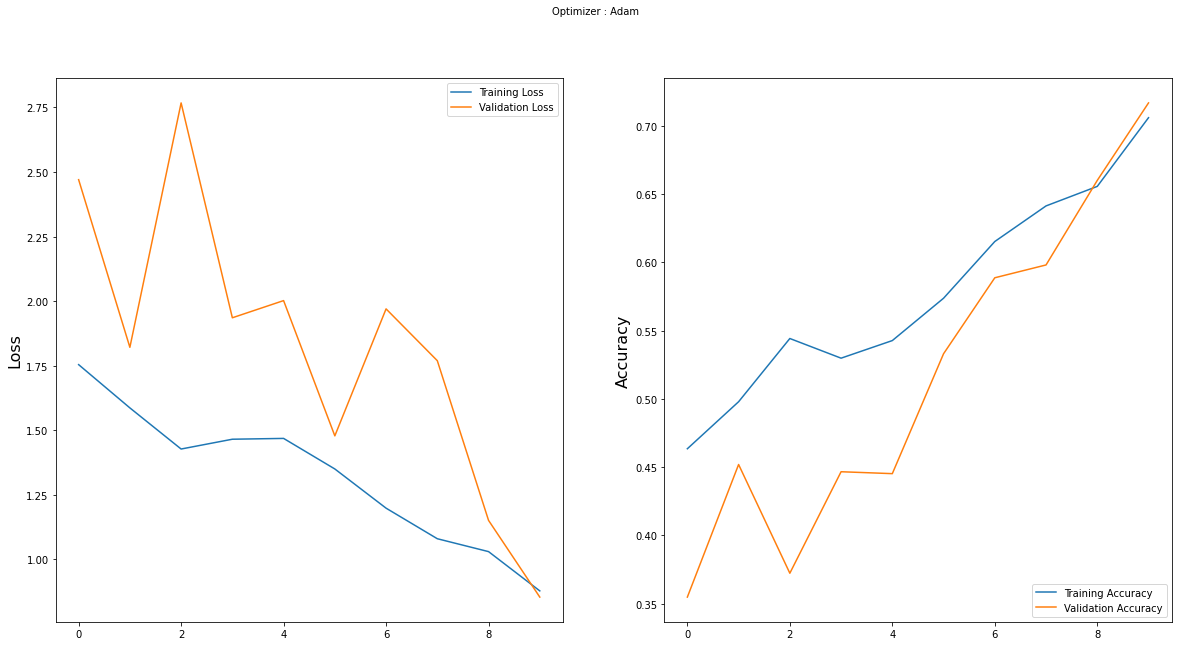

In [68]:
plot_history(historyfine)

in part 4, we observe improvment in accuracy and loss. model trained good and train and validation datasets are following a trend.